# ```sampley``` exemplar: the point approach (with continuous datapoints)
Before going through this exemplar, please consult the Introduction to sampley exemplars (```intro.ipynb```).
<br>This exemplar illustrates an application of the point approach to data contained within a single file (```trackpoints.csv```) containing continuous datapoints (i.e., datapoints recorded at frequent, regular intervals) that can be joined to construct survey tracks.
<br>It differs from the standard point exemplar as having continuous datapoints allows for certain procedures to be applied in Stage 3 that may be more efficient and precise.

## Setup

### Import the package

In [1]:
from sampley import *

### Set the import folder
To run this exemplar, download the mock data files, put them in a folder, and set the path to the folder below.

In [2]:
import_folder = './import/'

### Set the export folder
To run this exemplar, make a folder to save the samples in and set the path to the folder below.

In [3]:
export_folder = './export/'

## Stage 1
In Stage 1, we import a single file (```trackpoints.csv```) to make a ```DataPoints``` object, from which we then make a ```Sections``` object.
<br>Although we use a CSV file in this exemplar, there are other options for file types (including XLSX, GPKG, and SHP files). Please see the Stage 1 exemplar (```stage-1.ipynb```) in the horizontal exemplars folder or the User Manual for more details. Note that, regardless of the imported file type, once any ```DataPoints``` and/or ```Sections``` objects have been made, the subsequent processing will be the same.

In [4]:
u_trackpoints = DataPoints.from_file(
    filepath=import_folder+'trackpoints.csv',
    x_col='lon',
    y_col='lat',
    crs_import='EPSG:4326',
    crs_working='EPSG:32619',
    datetime_col='datetime',
    tz_import='UTC-05:00',
    section_id_col='section_id'  
)

Success: file opened.
Success: X and Y coordinates parsed.
Success: reprojected to CRS "EPSG:32619"
Success: column "datetime" reformatted to datetimes.
Success: timezone of column "datetime" set to "UTC-05:00".
Success: datapoint IDs generated.


In [5]:
u_sections = Sections.from_datapoints(datapoints=u_trackpoints)

## Stage 2
In the first part of Stage 2, we use the ```DataPoints``` object containing sightings data to make a ```Presences``` object (```u_presences```).

In [6]:
u_presences = Presences.delimit(
    datapoints=u_trackpoints,
    presence_col='individuals')

In [7]:
u_presences.presences[:5]  # print the first five rows of the presences GeoDataFrame

,point_id,point,date,datapoint_id
0,p01,POINT (579166.78 4742872.701),2019-01-25,d0004
1,p02,POINT (554184.217 4742741.886),2019-01-25,d0068
2,p03,POINT (548599.876 4742700.214),2019-01-25,d0082
3,p04,POINT (520909.741 4714855.058),2019-03-02,d0480
4,p05,POINT (532548.249 4714899.835),2019-03-02,d0510


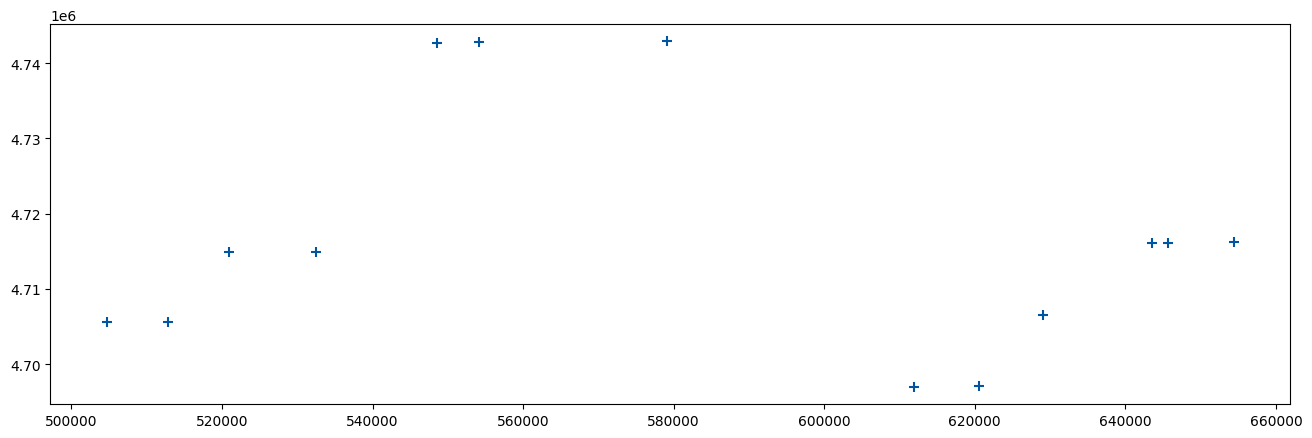

In [8]:
u_presences.plot()  # plot the presences

Then, we use the ```Presences``` object and the ```Sections``` object to make a ```PresenceZones``` object (```u_presencezones```) based on a spatial threshold of 10000 m and a temporal threshold of 5 days.

In [9]:
u_presencezones = PresenceZones.delimit(
    sections=u_sections,
    presences=u_presences,
    sp_threshold=10000,
    tm_threshold=5,
    tm_unit='day',
)

In [10]:
u_presencezones.presencezones  # print the presence zones GeoDataFrame

,section_id,presencezones
0,s001,"MULTIPOLYGON (((550550.779 4732892.362, 549580..."
1,s002,"MULTIPOLYGON (((550550.779 4732892.362, 549580..."
2,s003,"MULTIPOLYGON (((613927.76 4687166.258, 612957...."
3,s004,"MULTIPOLYGON (((613927.76 4687166.258, 612957...."


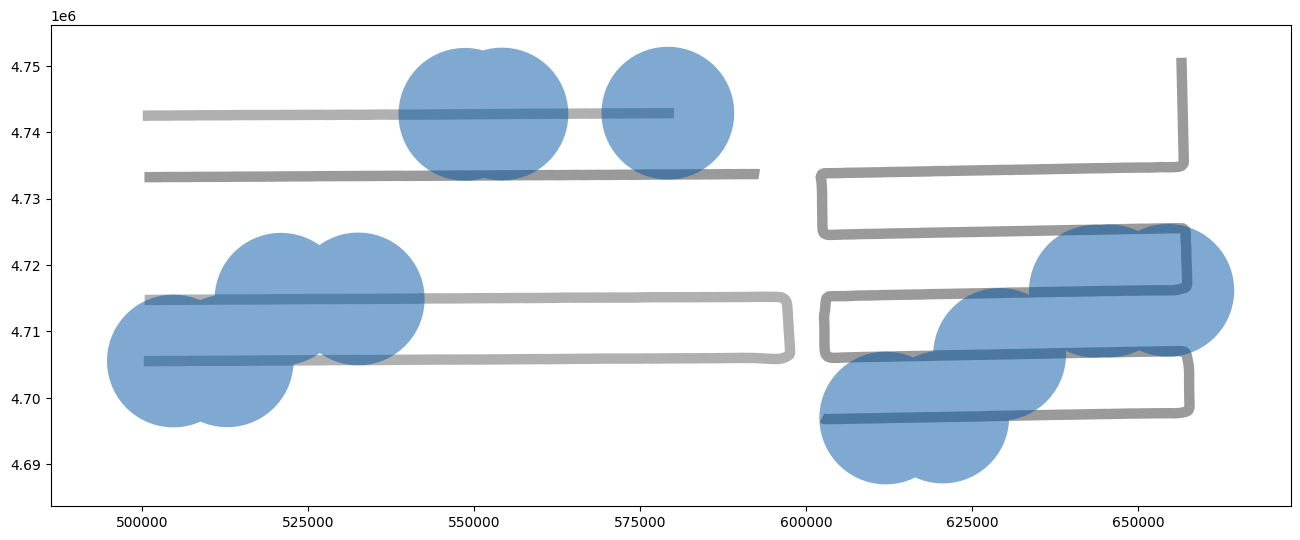

In [11]:
u_presencezones.plot(sections=u_sections)  # plot the presence zones (in blue) over the sections (in grey)

Finally, we use the ```Sections``` object and the ```PresenceZones``` object to make an ```Absences``` object (```u_absences```).
<br>Note that the target number of absences to generate is set to five times the number of presences.

In [12]:
u_absences = Absences.delimit(
    sections=u_sections,
    presencezones=u_presencezones,
    var='along',
    target=5*len(u_presences.presences))

Target: 65 | Attempts: 116 | Successes: 65


In [13]:
u_absences.absences[:5]  # print the first five rows of the absences GeoDataFrame

,point_id,point,date,section_id,dfbs
0,a01,POINT (530788.213 4742635.312),2019-01-25,s001,49309.352290
1,a02,POINT (529365.251 4742629.099),2019-01-25,s001,50732.327544
2,a03,POINT (504801.359 4742523.974),2019-01-25,s001,75298.201235
3,a04,POINT (588531.506 4733693.282),2019-01-30,s002,84402.983296
4,a05,POINT (584842.285 4733666.567),2019-01-30,s002,88092.646731


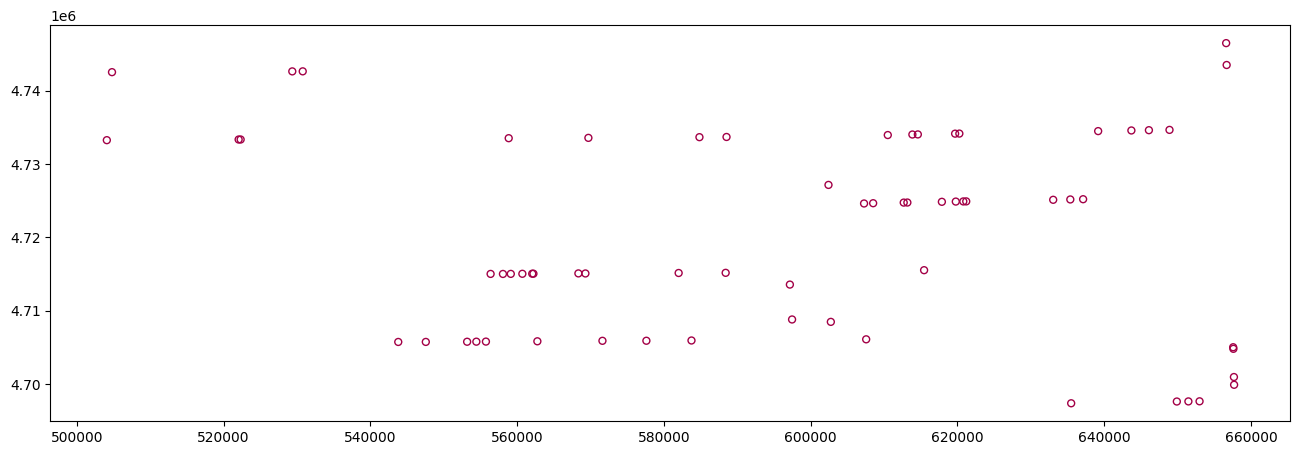

In [14]:
u_absences.plot()  # plot the absences

## Stage 3
In Stage 3, we make a ```Samples``` object from the ```Presences``` object and the ```Absences``` object. We also import the ```DataPoints``` objects that contain the data to assign to the presences and absences (in our case these are the same ```DataPoints``` object) and lists of the data columns to assign.
<br>_Note that assigning data to the absences is only possible because the absences are made from sections that are made from continuous datapoints. This means that we can match those datapoints to the absences by their distance from the beginning of the sections._

In [15]:
u_samples = Samples.point(
    presences=u_presences,
    absences=u_absences,
    datapoints_p=u_trackpoints,  # DataPoints object containing data to assign to the presences
    cols_p=['individuals', 'bss', 'section_id'],  # data columns in datapoints_p to assign to the presences
    datapoints_a=u_trackpoints,  # DataPoints object containing data to assign to the absences
    cols_a=['individuals', 'bss'])  # data columns in datapoints_a to assign to the absences (note: section_id not necessary as it is already in the absences by default)

In [16]:
print(f'Number of samples: {len(u_samples.samples)}')

Number of samples: 78


In [17]:
u_samples.samples[:5]  # print the first five rows of the samples GeoDataFrame

,point_id,point,date,datapoint_id,p-a,individuals,bss,section_id,dfbs
0,p01,POINT (579166.78 4742872.701),2019-01-25,d0004,1,1.0,2,s001,NaN
1,p02,POINT (554184.217 4742741.886),2019-01-25,d0068,1,2.0,2,s001,NaN
2,p03,POINT (548599.876 4742700.214),2019-01-25,d0082,1,5.0,2,s001,NaN
3,p04,POINT (520909.741 4714855.058),2019-03-02,d0480,1,1.0,1,s003,NaN
4,p05,POINT (532548.249 4714899.835),2019-03-02,d0510,1,2.0,1,s003,NaN


We know that, due to the presence zones, no absence will be within the spatial and temporal thresholds of a presence, however, by looking at the plots of the presences in Stage 2 above, we may see that some of the presences are close to other presences. The same applies to the absences. This may lead to issues associated with autocorrelation.
<br>So, here, we thin the samples with a spatial threshold of 10000 m and a temporal threshold of 5 days, resulting in 25 samples that are kept (within the ```samples``` attribute).

In [18]:
u_samples.thin(
    coords='point', 
    sp_threshold=10000,
    datetimes='date',
    tm_threshold=5,
    tm_unit='day'
)

In [19]:
print(f'Number of samples kept: {len(u_samples.samples)}')

Number of samples kept: 33


In [20]:
u_samples.samples[:5]  # print the first five rows of the samples GeoDataFrame

,point_id,point,date,datapoint_id,p-a,individuals,bss,section_id,dfbs
0,p01,POINT (579166.78 4742872.701),2019-01-25,d0004,1,1.0,2,s001,NaN
1,p02,POINT (554184.217 4742741.886),2019-01-25,d0068,1,2.0,2,s001,NaN
2,p04,POINT (520909.741 4714855.058),2019-03-02,d0480,1,1.0,1,s003,NaN
3,p05,POINT (532548.249 4714899.835),2019-03-02,d0510,1,2.0,1,s003,NaN
4,p06,POINT (512817.407 4705582.465),2019-03-02,d0910,1,1.0,1,s003,NaN


Those samples that were removed by thinning are now in a new attribute: ```removed```.

In [21]:
print(f'Number of samples removed: {len(u_samples.removed)}')

Number of samples removed: 45


In [22]:
u_samples.removed[:5]  # print the first five rows of the removed samples GeoDataFrame

,point_id,point,date,datapoint_id,p-a,individuals,bss,section_id,dfbs
0,p03,POINT (548599.876 4742700.214),2019-01-25,d0082,1,5.0,2,s001,NaN
1,p07,POINT (504710.41 4705553.392),2019-03-02,d0930,1,3.0,1,s003,NaN
2,p09,POINT (645666.237 4716110.937),2019-03-05,d1330,1,2.0,2,s004,NaN
3,p12,POINT (620560.818 4697116.949),2019-03-05,d1715,1,2.0,3,s004,NaN
4,a02,POINT (529365.251 4742629.099),2019-01-25,d0130,0,NaN,3,s001,50732.327544


## Export
Finally, we save the final ```Samples``` object to the export folder.

In [23]:
u_samples.save(
    folder=export_folder,
    filetype='csv',
    crs_export='EPSG:4326'
)

Success: reprojected to CRS "EPSG:4326"


In the export folder, there should be two new CSVs: the first should have the same name as the ```Samples``` object (run the box below to see the name) while the second should also have this name but with ```-parameters``` added at the end.

In [24]:
u_samples.name

'samples-presences-trackpoints-+-absences-as-10000m-5day'

The first CSV should contain the samples, like those shown in the box below. 
<br>In this dataframe, each row represents a given presence or absence, i.e., a sample. 
<br>The column ```point``` delimits the location of the presence/absence.
<br>In this particular example, the data columns are ```p-a``` (presence-absence), ```individuals```, and ```bss```.

In [25]:
u_samples.samples

,point_id,point,date,datapoint_id,p-a,individuals,bss,section_id,dfbs
0,p01,POINT (579166.78 4742872.701),2019-01-25,d0004,1,1.0,2,s001,NaN
1,p02,POINT (554184.217 4742741.886),2019-01-25,d0068,1,2.0,2,s001,NaN
2,p04,POINT (520909.741 4714855.058),2019-03-02,d0480,1,1.0,1,s003,NaN
3,p05,POINT (532548.249 4714899.835),2019-03-02,d0510,1,2.0,1,s003,NaN
4,p06,POINT (512817.407 4705582.465),2019-03-02,d0910,1,1.0,1,s003,NaN
5,p08,POINT (654449.136 4716189.584),2019-03-05,d1306,1,5.0,1,s004,NaN
6,p10,POINT (643532.681 4716066.52),2019-03-05,d1336,1,1.0,2,s004,NaN
7,p11,POINT (629124.489 4706545.106),2019-03-05,d1527,1,3.0,2,s004,NaN
8,p13,POINT (611976.857 4696974.111),2019-03-05,d1739,1,4.0,3,s004,NaN
9,a01,POINT (530788.213 4742635.312),2019-01-25,d0127,0,NaN,3,s001,49309.352290


The second CSV should contain the parameters, like those shown in the box below (but arranged in a table). This information may prove useful if, later, we need to know  how the samples were generated.

In [26]:
u_samples.parameters

{'approach': 'point',
 'resampled': 'datapoints',
 'presences_name': 'presences-trackpoints',
 'presences_crs': 'EPSG:32619',
 'absences_name': 'absences-as-10000m-5day',
 'absences_var': 'along',
 'absences_target': 65,
 'presencezones_crs': 'EPSG:32619',
 'presencezones_sp_threshold': 10000,
 'presencezones_tm_threshold': 5,
 'presencezones_tm_unit': 'day',
 'sp_threshold': 10000,
 'tm_threshold': 5,
 'tm_unit': 'day'}